<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 9: Filterung
## Synthetischer Brockenpluton: Horizontal derivative via FFT
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

We use a synthetic data set of the **Brocken pluton** for testing our filter algorithms.
<img src="figures/brockenpluton.jpg" style=width:10cm>

Our tasks are:
- create irregular synthetic data, add random noise, add linear trend
- create gridd data from irregular data
- detrend data (least squares fit)
- upward continuation of data (FFT)
- spatial derivatives of data (FFT)
- ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import lib_modelling
tiny=1e-15

In [2]:
lib_modelling.change_fontsize(SMALL_SIZE=12)

----
We first **load** gridded data created in the last notebook...

In [3]:
infile = 'Brocken_detrended.npy'
data = np.load(infile)    
print(data.shape)
X = data[0,:,:]
Y = data[1,:,:]
boug = data[2,:,:]

(3, 100, 100)


In [4]:
xmin = X.min()
xmax = X.max()
ymin = Y.min()
ymax = Y.max()
nx = X.shape[0]
ny = Y.shape[1]
print(xmin,xmax,ymin,ymax,nx,ny)

-50000.0 50000.0 -50000.0 50000.0 100 100


----
## Create 2D wavenumber field

...

In [5]:
kx     = (-nx/2 + np.arange(0,nx))*2*np.pi/(xmax-xmin)
ky     = (-ny/2 + np.arange(0,ny))*2*np.pi/(ymax-ymin)
KX, KY = np.meshgrid(kx, ky)
print(KX.shape,KY.shape)

(100, 100) (100, 100)


### Forward FFT of Bouguer gravity data

In [6]:
# forward 2D FFT
F      = np.fft.fft2(boug)
F      = np.fft.fftshift(F)  # Shift the zero-frequency component to the center of the spectrum.
power  = np.abs(F)**2
power  = 20*np.log10((power+tiny)/power.max())
F      = np.fft.ifftshift(F)

print(F.shape)

(100, 100)


### Horizontal derivatives as filter in spectral domain
$$
\begin{array}{rcl}
\frac{\partial g}{\partial x} &=& \cal{F}^{-1} \left[ \cal{F}[g] \cal{F}[\Psi_{dx}] \right] \\
\frac{\partial g}{\partial y} &=& \cal{F}^{-1} \left[ \cal{F}[g] \cal{F}[\Psi_{dy}] \right]
\end{array}
$$
$$
\begin{array}{rcl}
\cal{F}[\Psi_{dx}] &=& i k_x \\
\cal{F}[\Psi_{dy}] &=& i k_y
\end{array}
$$

Combine to:
$$
\frac{\partial g}{\partial h} = \sqrt{
\frac{\partial g}{\partial x}^2
+\frac{\partial g}{\partial y}^2 }
$$

In [7]:
n=1
Fdx = np.power(1j*KX,n)
Fdy = np.power(1j*KY,n)

### Inverse FFT of filtered Bouguer gravity data

In [11]:
# inverse 2D FFT
#F2             = np.fft.ifftshift(F)
F2 = np.copy(F)
dfdx = np.fft.ifft2(F2*np.fft.fftshift(Fdx)).real
F2 = np.copy(F)
dfdy = np.fft.ifft2(F2*np.fft.fftshift(Fdy)).real
boug_dfdh = np.sqrt(dfdx**2 + dfdy**2)
print(boug_dfdh.min(),boug_dfdh.max())
norm = np.abs(boug_dfdh).max()
print(norm)
#norm=1.

2.81495971970942e-05 0.02949294797689029
0.02949294797689029


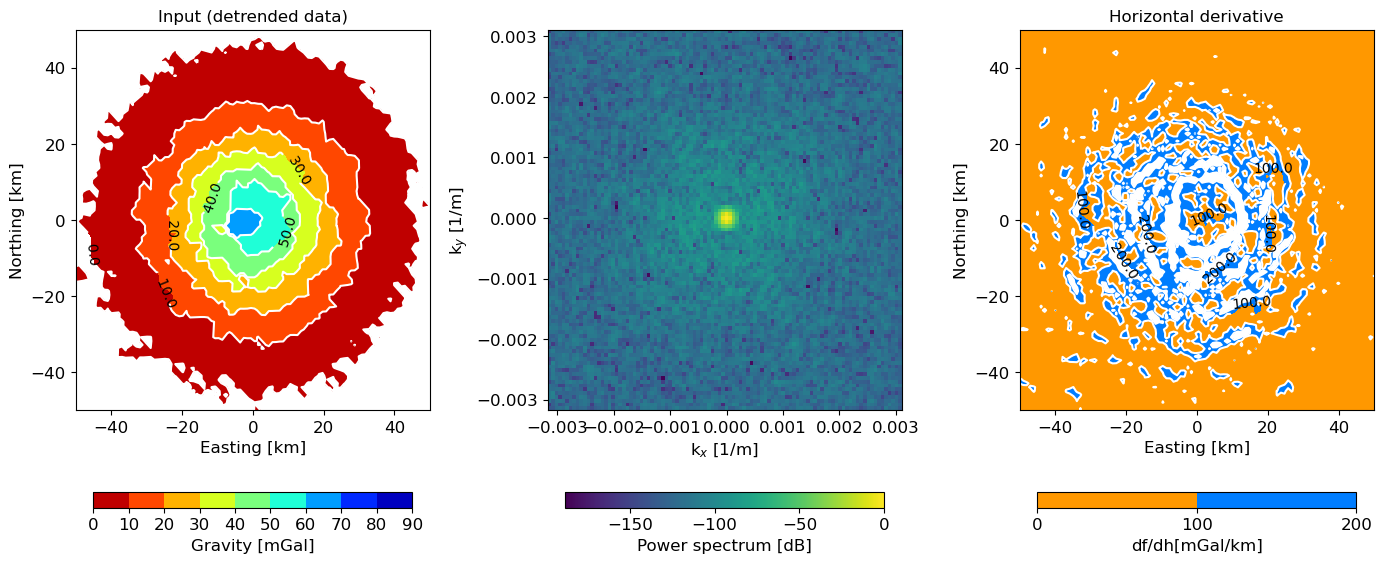

In [14]:
fig,axs = plt.subplots(1,3,figsize=(14.0,6.0))
color_levels=[0,10,20,30,40,50,60,70,80,90]
dfdh_levels=[0,30,60,90,120,150]
dfdh_levels=[0,100,200]

axs[0].set_title('Input (detrended data)')
axs[0].set_xlabel('Easting [km]')
axs[0].set_ylabel('Northing [km]')
CS1=axs[0].contourf(X/1e3, Y/1e3, boug,cmap=plt.cm.jet_r,levels=color_levels)
CS2=axs[0].contour(X/1e3, Y/1e3, boug,colors='white',levels=color_levels)
axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Gravity [mGal]')

axs[1].set_xlabel('k$_x$ [1/m]')
axs[1].set_ylabel('k$_y$ [1/m]')
#CS5=axs[1].pcolormesh(KX,KY,np.abs(F))
CS5=axs[1].pcolormesh(KX,KY,power)
cbar = fig.colorbar(CS5,ax=axs[1],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Power spectrum [dB]')

axs[2].set_title('Horizontal derivative')
axs[2].set_xlabel('Easting [km]')
axs[2].set_ylabel('Northing [km]')
CS3=axs[2].contourf(X/1e3, Y/1e3, 1e3*boug_dfdh/norm,cmap=plt.cm.jet_r,levels=dfdh_levels)
CS4=axs[2].contour(X/1e3, Y/1e3, 1e3*boug_dfdh/norm,colors='white',levels=dfdh_levels)
axs[2].clabel(CS4, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS3,ax=axs[2],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('df/dh[mGal/km]')

plt.tight_layout()

----
## Save data to file

In [10]:
# save to file
outfile =  'Brocken_FFTdfdh.npy'
np.save(outfile,[X,Y,boug_dfdh])

[next>](AGII_chap09_Brocken_FFTverticalderivative.ipynb)

----